In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS

/home/hadoop/IPythonNB/venv/local/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the training data

In [2]:
# Define file paths and data schemas

trainingText = sc.textFile('s3n://uwong.expedia.hotel/training_data/train.csv.gz')

# Parse text into RDDs

trainingData = (trainingText
    .map(lambda x: x.split('\n'))
    .map(lambda x: x[0].split(','))
)

# Save column header
columnNames = trainingData.first()

dfTrainingData = (trainingData
    .filter(lambda x: x != columnNames) # remove header
    .toDF(columnNames)
)

dfTrainingData.show()

+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+----------+---+---------------+-------------+------------+-------------+
|          date_time|site_name|posa_continent|user_location_country|user_location_region|user_location_city|orig_destination_distance|user_id|is_mobile|is_package|channel|   srch_ci|   srch_co|srch_adults_cnt|srch_children_cnt|srch_rm_cnt|srch_destination_id|srch_destination_type_id|is_booking|cnt|hotel_continent|hotel_country|hotel_market|hotel_cluster|
+-------------------+---------+--------------+---------------------+--------------------+------------------+-------------------------+-------+---------+----------+-------+----------+----------+---------------+-----------------+-----------+-------------------+------------------------+--

# Take a small sample of the data (from 37 million down to 37,000)

In [5]:
# Take a smaller sample for faster debugging
dfTrainingSample = dfTrainingData.sample(withReplacement=False, fraction=0.001, seed=42)
dfTrainingSample.cache()
dfTrainingSample.registerTempTable('training_data')

# Transform data to count bookings and clicks by user_id and hotel_cluster

In [76]:
# For each booking row

dfBookings = (dfTrainingSample
                    .filter(dfTrainingSample.is_booking == 1)
                    .groupBy(['user_id', 'hotel_cluster'])
                    .agg(F.count('is_booking').alias('num_bookings'))
              )
dfBookings.show()

# Join the number of preceding clicks 

+-------+-------------+------------+
|user_id|hotel_cluster|num_bookings|
+-------+-------------+------------+
|   9681|           10|           1|
| 984866|            0|           1|
| 957456|            5|           1|
|1135134|           18|           1|
| 482707|           52|           1|
| 577587|           82|           1|
| 615209|           11|           1|
| 343514|           21|           1|
| 698844|           28|           1|
|1089582|           95|           1|
| 223086|            8|           1|
|1104571|           11|           1|
| 865557|           16|           1|
|1167188|            9|           1|
| 959311|            1|           1|
| 964155|           72|           1|
| 863477|           14|           1|
| 694346|           82|           1|
| 721707|           75|           1|
| 212883|           64|           1|
+-------+-------------+------------+
only showing top 20 rows



In [77]:
dfBookings.select('num_bookings').describe().show()

+-------+--------------------+
|summary|        num_bookings|
+-------+--------------------+
|  count|                2989|
|   mean|  1.0006691201070592|
| stddev|0.025863027109764552|
|    min|                   1|
|    max|                   2|
+-------+--------------------+



In [78]:
dfClicks = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.count('is_booking').alias('num_clicks'))
            )
dfClicks.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_clicks|
+-------+-------------+----------+
| 378005|           66|         1|
| 712896|            6|         1|
| 940050|            1|         1|
| 983231|           70|         1|
| 369280|           34|         1|
| 652925|           91|         1|
|1064706|           98|         1|
| 233455|           58|         1|
| 901105|           70|         1|
|1073211|           37|         1|
|  31266|           58|         1|
| 965057|           14|         1|
| 461083|           81|         1|
| 734817|           18|         1|
| 957456|            5|         1|
|1153899|           85|         1|
|1197819|           85|         1|
| 124833|           37|         1|
| 384958|           40|         1|
| 516769|           96|         1|
+-------+-------------+----------+
only showing top 20 rows



In [80]:
dfClicks.select('num_clicks').describe().show()

+-------+-------------------+
|summary|         num_clicks|
+-------+-------------------+
|  count|              34426|
|   mean| 1.0025852553302737|
| stddev|0.05246845364783292|
|    min|                  1|
|    max|                  4|
+-------+-------------------+



In [90]:
dfEvents = (dfTrainingSample
            .filter(dfTrainingSample.is_booking == 0)
            .groupBy(['user_id', 'hotel_cluster'])
            .agg(F.sum('cnt').cast('int').alias('num_events'))
            )
dfEvents.show()

+-------+-------------+----------+
|user_id|hotel_cluster|num_events|
+-------+-------------+----------+
| 378005|           66|         1|
| 712896|            6|         1|
| 940050|            1|         1|
| 983231|           70|         1|
| 369280|           34|         1|
| 652925|           91|         1|
|1064706|           98|         1|
| 233455|           58|         1|
| 901105|           70|         8|
|1073211|           37|         1|
|  31266|           58|         1|
| 965057|           14|         2|
| 461083|           81|         1|
| 734817|           18|         3|
| 957456|            5|         1|
|1153899|           85|         2|
|1197819|           85|         2|
| 124833|           37|         2|
| 384958|           40|         1|
| 516769|           96|         1|
+-------+-------------+----------+
only showing top 20 rows



In [91]:
dfEvents.select('num_events').describe().show()

+-------+------------------+
|summary|        num_events|
+-------+------------------+
|  count|             34426|
|   mean|1.5269273223726254|
| stddev|1.2417517363165582|
|    min|                 1|
|    max|                27|
+-------+------------------+



In [93]:
dfBookingClicks = (dfBookings
                  .join(dfClicks, 
#                         on=(dfBookings.user_id == dfClicks.user_id) & (dfBookings.hotel_cluster == dfClicks.hotel_cluster), 
                        on=['user_id', 'hotel_cluster'],
                        how='outer')
                   .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks')
                  )

dfBookingClicksEvents = (dfBookingClicks
                         .join(dfEvents, 
                            on=['user_id', 'hotel_cluster'],
                            how='outer')
                         .select('user_id', 'hotel_cluster', 'num_bookings', 'num_clicks', 'num_events')
                         .na.fill(0)
                        )
dfBookingClicksEvents.show()

+-------+-------------+------------+----------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|
+-------+-------------+------------+----------+----------+
|1024567|           64|           0|         1|         1|
|1037993|           65|           0|         1|         5|
|1041372|           63|           0|         1|         2|
|1043123|           25|           0|         1|         1|
|1046637|           60|           0|         1|         1|
|1057669|           43|           0|         1|         2|
|1064706|           98|           0|         1|         1|
|1071150|           19|           0|         1|         2|
|1072629|           33|           0|         1|         1|
|1073211|           37|           0|         1|         1|
|1079176|           62|           0|         1|         1|
|1085095|           90|           0|         1|         1|
|1089582|           95|           1|         0|         0|
|1090007|            4|           0|         1|         

# Create rating columns that combines bookings and clicks into a single value

In [96]:
bookingWeight = 5
dfBookingClicksEventsRating = (dfBookingClicksEvents
                               .withColumn('rating', 
                                           bookingWeight * dfBookingClicksEvents.num_bookings +  dfBookingClicksEvents.num_events)
                               )
dfBookingClicksEventsRating.show()

+-------+-------------+------------+----------+----------+------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|
+-------+-------------+------------+----------+----------+------+
|1024567|           64|           0|         1|         1|     1|
|1037993|           65|           0|         1|         5|     5|
|1041372|           63|           0|         1|         2|     2|
|1043123|           25|           0|         1|         1|     1|
|1046637|           60|           0|         1|         1|     1|
|1057669|           43|           0|         1|         2|     2|
|1064706|           98|           0|         1|         1|     1|
|1071150|           19|           0|         1|         2|     2|
|1072629|           33|           0|         1|         1|     1|
|1073211|           37|           0|         1|         1|     1|
|1079176|           62|           0|         1|         1|     1|
|1085095|           90|           0|         1|         1|     1|
|1089582| 

In [97]:
dfBookingClicksEventsRating.select('num_bookings', 'num_clicks', 'num_events', 'rating').describe().show()

+-------+------------------+-------------------+------------------+------------------+
|summary|      num_bookings|         num_clicks|        num_events|            rating|
+-------+------------------+-------------------+------------------+------------------+
|  count|             37401|              37401|             37401|             37401|
|   mean|0.0799711237667442| 0.9228362877997914|1.4054704419667923|1.8053260608005133|
| stddev|0.2714491891086528|0.27591876306726987| 1.260952453309527| 1.521007784479165|
|    min|                 0|                  0|                 0|                 1|
|    max|                 2|                  4|                27|                27|
+-------+------------------+-------------------+------------------+------------------+



# Fit the recommender model

In [99]:
als = ALS(rank=10, maxIter=5, implicitPrefs=True,
                          userCol="user_id", itemCol="hotel_cluster", ratingCol="rating")
recommendationModel = als.fit(dfBookingClicksEventsRating)

# Examine predictions made onto the same training data

In [102]:
# predict the 'ratings' (num_clicks) a user will make for each 
dfPredictions = recommendationModel.transform(dfBookingClicksEventsRating)

In [105]:
dfPredictionsSorted = (dfPredictions
                       .orderBy('prediction', ascending=False))
dfPredictionsSorted.show()

+-------+-------------+------------+----------+----------+------+----------+
|user_id|hotel_cluster|num_bookings|num_clicks|num_events|rating|prediction|
+-------+-------------+------------+----------+----------+------+----------+
| 421228|           91|           0|         1|        11|    11|0.90930957|
| 772435|           91|           0|         1|         9|     9| 0.8931101|
| 407285|           91|           0|         1|         9|     9| 0.8931101|
| 915950|           65|           0|         1|        19|    19|0.88791215|
| 251628|           65|           0|         1|        18|    18| 0.8827048|
| 476363|           65|           0|         1|        17|    17|0.87698996|
|1037837|           91|           0|         1|         7|     7| 0.8698652|
| 282191|           91|           0|         1|         7|     7| 0.8698652|
| 575536|           64|           0|         1|        13|    13|0.86136615|
|1113225|           65|           0|         1|        14|    14| 0.8559323|

In [106]:
dfPredictionsSorted.select('prediction').describe().show()

+-------+-------------------+
|summary|         prediction|
+-------+-------------------+
|  count|              37401|
|   mean|0.25804449174448296|
| stddev|0.17601403170185298|
|    min|        -0.08518164|
|    max|         0.90930957|
+-------+-------------------+



# Evaluate the predictions

See if there is a correlation between the prediction we made and bookings, clicks, and combined rating

In [117]:
predictionRows = (dfPredictionsSorted
               .select('num_bookings', 'num_events', 'rating', 'prediction')
               ).collect()

In [119]:
bookings = [row.num_bookings for row in predictionRows]
events = [row.num_events for row in predictionRows]
ratings = [row.rating for row in predictionRows]
predictions = [row.prediction for row in predictionRows]

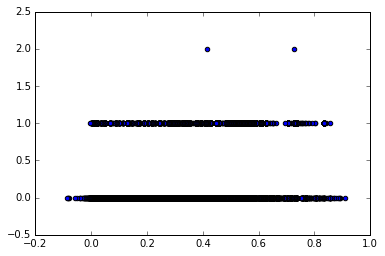

In [116]:
plt.scatter(preds, bookings)

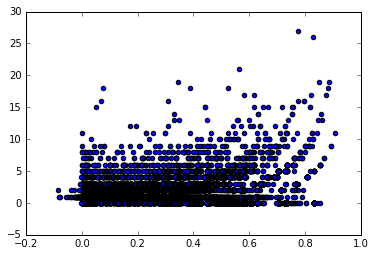

In [120]:
plt.scatter(preds, events)

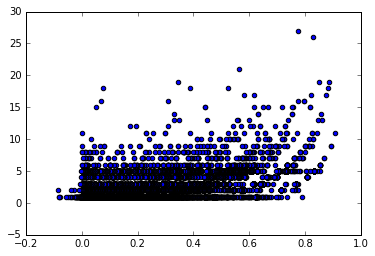

In [121]:
plt.scatter(preds, ratings)

In [107]:
import pandas as pd
pdPredictions = dfPredictionsSorted.toPandas()

ImportError: No module named pandas